# Adaptive Momentum Using Fuzzy Inference System
A FIS is created which takes in the changes in validation and training losses over a few epochs and changes the momentum of the SGD optimizer accordingly.

#### Importing the necessary libraries and loading the dataset:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.optimizers import SGD
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import PReLU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow import python as tfp

# Base number of neurons in one hidden layer
N = 30
# Number of epochs
EPO = 50
# Initial Momentum
IM = 0.3

# Loading the fashion mnist dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Flattening the images into one dimensional vectors
x_train = x_train.reshape((60000, 784))
x_test = x_test.reshape((10000, 784))

# Changing the labeling format to one hot labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#### Building the network:

In [ ]:
inp_layer = Input(shape=(784,))
hidden_layer1 = Dense(units=N, activation='linear')(inp_layer)
hidden_layer1 = PReLU()(hidden_layer1)
hidden_layer2 = Dense(units=N, activation='linear')(hidden_layer1)
hidden_layer2 = PReLU()(hidden_layer2)
hidden_layer3 = Dense(units=N, activation='linear')(hidden_layer2)
hidden_layer3 = PReLU()(hidden_layer3)
hidden_layer4 = Dense(units=N, activation='linear')(hidden_layer3)
hidden_layer4 = PReLU()(hidden_layer4)
out_layer = Dense(units=10, activation='softmax')(hidden_layer4)

mlp_model = Model(inputs=inp_layer, outputs=out_layer)

mlp_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_25 (Dense)             (None, 30)                23550     
_________________________________________________________________
p_re_lu (PReLU)              (None, 30)                30        
_________________________________________________________________
dense_26 (Dense)             (None, 30)                930       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 30)                30        
_________________________________________________________________
dense_27 (Dense)             (None, 30)                930       
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 30)                30  

#### Building the Fuzzy Inference System:

In [ ]:
def trimf(param, inp):
    """
    Takes in the 3 parameters of a triangular membership function along with the input and outputs the corresponding
    membership of the given input.
    params:
        param: Array of 3 numbers indicating the 3 points of a triangular membership function
        inp: Numpy array as the input to the membership function
    """
    output = np.maximum(np.minimum((inp - param[0]) / (param[1] - param[0]),
                                   (param[2] - inp) / (param[2] - param[1])), 0)
    return output


def trapmf(param, inp):
    """
    Takes in the 4 parameters of a trapezoidal membership function along with the input, and outputs the corresponding
    membership of the given input.
    params:
        param: Array of 4 numbers indicating the 4 points of a trapezoidal membership function
        inp: Numpy array as the input to the membership function
    """
    output = np.maximum(np.minimum(np.minimum((inp - param[0]) / (param[1] - param[0]), 1),
                                   np.minimum((param[3] - inp) / (param[3] - param[2]), 1)), 0)
    return output


class FuzzySets(object):
    """
    This class is written to define a fuzzy set for either a set of input or output. Here, by fuzzy set
    we refer to a set of membership functions.
    """
    def __init__(self):
        self.mfs = {}
        self.rng = [-10, 10]  # Fuzzy set range

    def add_mf(self, mf_name, mf_type, mf_params):
        """
        This function adds a membership function to the fuzzy set.
        params:
            mf_name: string, the name for membership function. You can
                     use any names. Note that this name will be used when
                     you want to define the rules or evaluate the membership
                     function for a given input.
            mf_type: string, the type of the membership function can be "trimf"
                     or "trapmf" at this time.
            mf_params: The parameters for the membership function. ]f you choose
                       "trimf" you need to enter an array of 3 values and if you
                       enter "trapmf" you should enter an array of 4 values.
        """

        for i in range(len(mf_params) - 1):
            assert mf_params[i] <= mf_params[i + 1], 'Parameter ' + \
                                                     str(i) + "should be less than or equal to parameter" + str(i + 1)
            if mf_params[i] == mf_params[i + 1]:
                mf_params[i + 1] += 0.0000001
        # A dictionary for restoring the type and parameters of each membership function
        self.mfs[mf_name] = {'type': mf_type, 'params': mf_params}

    def eval_mf(self, mf_name, inp):
        """
        Given the name of membership function and input value, this function
        evaluates the membership of that input to the membership function.
        params:
            mf_name: the name of the membership function.
            inp: a scalar or a numpy array.
        """
        if type(inp) in [float, int]:
            inp = np.array(inp)
        elif type(inp) == tfp.ops.resource_variable_ops.ResourceVariable:
            inp = inp.numpy()

        if self.mfs[mf_name]['type'] == 'trimf':
            output = trimf(self.mfs[mf_name]['params'], inp)
        elif self.mfs[mf_name]['type'] == 'trapmf':
            output = trapmf(self.mfs[mf_name]['params'], inp)

        return output

################################################################################################################################


class FIS:

    def __init__(self, inputs={},
                 outputs={},
                 rules={},
                 defuzzification='com',  # Center Of Mass
                 and_method='min',
                 or_method='max',
                 resolution=0.0001):
        """
        params:
            inputs: A dictionary with keys indicating the names for the input sets
                    and values specifying FuzzySet objects. (For the time being, only up
                    to two inputs are accepted)
            outputs: A dictionary with keys indicating the names for the output sets
                    and values specifying FuzzySet objects.
            rules: A dictionary with keys indicating the names for the rules
                    and values specifying a rule in a string format.
                    e.g.: {'rule1': 'if inp1 is mf2 and inp2 is mf5 then output is mf3',
                           'rule2': 'if inp1 is mf1 or inp2 is mf4 then output is mf1',}
            defuzzification: A string indicating the defuzzification method. At this time
                             only 'com' (center of mass) is available.
            AndMethod: A string, either 'min' or 'product'
            OrMethod : A string, either 'max' or 'sum'
            resolution: The calculations are discrete, this parameter is a number that
                        shows the distance between samples.
        """
        self.inputs = inputs
        self.outputs = outputs
        self.rules = rules
        self.defuzzification = defuzzification
        self.and_method = and_method
        self.or_method = or_method
        self.resolution = resolution

    def add_rule(self, rule, rule_name=0):
        """
        This function adds a rule to the FIS.
        params:
            rule: a string. (e.g. if inp1 is mf1_3 and inp2 is mf2_1 then out1 is mf3_5)
            rule_name: you can specify a name to the rule, if you don't, a sequential
            naming method will be used by default.
        """
        if rule_name == 0:
            self.rules[len(self.rules)] = rule
        else:
            self.rules[rule_name] = rule

    def eval_rule(self, rule, inp):
        """
        This function evaluates a rule for the given inputs. The output is the
        membership of the activated output to the given input.
        params:
            rule: A string, indicating the rule to be evaluated
            inp: A dictionary with keys indicating the names of the inputs and
                 their corresponding values specifying the actual inputs.
        """
        if len(self.inputs) == 2:
            rule = rule.replace('is', '').replace('then', '').replace('if', '')
            rule = rule.split()  # Turns the rule string to a list
            # Evaluating the membership of the input sets for the given input
            mu_1 = self.inputs[rule[0]].eval_mf(rule[1], inp[rule[0]])
            mu_2 = self.inputs[rule[3]].eval_mf(rule[4], inp[rule[3]])

            if rule[2].lower() == 'and':
                # Checking if the rule is activated or not, to avoid unnecessary calculations
                if (mu_1 or mu_2) == 0:
                    out_rng = self.outputs[rule[5]].rng
                    output = np.zeros([int((out_rng[1] - out_rng[0]) / self.resolution), mu_1.shape[0]])
                    out_name = rule[5]
                    return output, out_name

                elif self.and_method == 'min':
                    mu = np.minimum(mu_1, mu_2)

                elif self.and_method == 'product':
                    mu = mu_1 * mu_2

            elif rule[2].lower() == 'or':
                # Checking if the rule is activated or not, to avoid unnecessary calculations
                if (mu_1 and mu_2) == 0:
                    out_rng = self.outputs[rule[5]].rng
                    output = np.zeros([int((out_rng[1] - out_rng[0]) / self.resolution), mu_1.shape[0]])
                    out_name = rule[5]
                    return output, out_name

                if self.or_method == 'max':
                    mu = np.maximum(mu_1, mu_2)

                elif self.or_method == 'sum':
                    mu = np.minimum(mu_1 + mu_2, 1)

            out_rng = self.outputs[rule[5]].rng
            out_interval = np.arange(out_rng[0], out_rng[1], self.resolution)
            output = self.outputs[rule[5]].eval_mf(rule[6], out_interval)
            output = np.repeat(output.reshape(-1, 1), mu.shape[0], axis=1)
            output = np.minimum(output, mu)
            out_name = rule[5]

        elif len(self.inputs) == 1:
            rule = rule.replace('is', '').replace('then', '').replace('if', '')
            rule = rule.split()  # Turns the rule string to a list
            # Evaluating the membership of the input sets for the given input
            mu = self.inputs[rule[0]].eval_mf(rule[1], inp[rule[0]])

            out_rng = self.outputs[rule[2]].rng
            # Checking if the rule is activated or not, to avoid unnecessary calculations
            if mu == 0:
                output = np.zeros([int((out_rng[1] - out_rng[0]) / self.resolution), mu.shape[0]])
                out_name = rule[2]
                return output, out_name
            out_interval = np.arange(out_rng[0], out_rng[1], self.resolution)
            output = self.outputs[rule[2]].eval_mf(rule[3], out_interval)
            output = np.repeat(output.reshape(-1, 1), mu.shape[0], axis=1)
            output = np.minimum(output, mu)
            out_name = rule[2]

        return output, out_name

    def evaluate(self, inp):
        """
        Evaluates all the rules in a FIS for a given set of inputs and returns the
        aggregate of all the activated output membership functions.
        params:
            inp: A dictionary with keys indicating the names of the inputs and
                 their corresponding values specifying the actual inputs.
        """
        # Creating a dictionary with keys indicating the output names and values being zero
        output = {out: 0 for out in self.outputs}

        for rule in self.rules:
            temp_output, temp_name = self.eval_rule(self.rules[rule], inp)
            output[temp_name] = np.maximum(temp_output, output[temp_name])

        return output

    def defuzzify(self, output):
        """
        This function takes in the aggregate of all the activated output membership
        functions and returns a defuzzied value.
        params:
            output: A numpy array consisting of the aggregate of the activated output
            membership functions
        """

        defuzzied = {}

        if self.defuzzification == 'com':

            for out in output:
                rng = self.outputs[out].rng
                x_interval = np.arange(rng[0], rng[1], self.resolution)

                y_temp = np.linspace(0, 1, 50).reshape(-1, 1)
                y_temp = np.repeat(y_temp, x_interval.shape[0], axis=1)
                y_temp = np.int32(y_temp <= output[out].T)
                x_com = np.sum(y_temp * x_interval / 50.0 * self.resolution)
                area = np.sum(np.array(output[out].tolist()[0:-1]) * self.resolution)
                defuzzied[out] = 0 if area == 0 else x_com / area

        return defuzzied

    def run(self, inputs):
        """
        Given a set of inputs, this function will calculate the output of the fuzzy
        inference system based on the specified rules.
        params:
            inputs: A dictionary with keys indicating the names of the inputs and
                 their corresponding values specifying the actual inputs.
        """
        for inp in inputs:
            if type(inputs[inp]) != np.ndarray:
                inputs[inp] = np.array([inputs[inp]])

        out_1 = self.evaluate(inputs)
        out_2 = self.defuzzify(out_1)

        return out_2


################################################################################################################################

# inp1 indicates the change in validation loss
inp1 = FuzzySets()
inp1.add_mf('De', 'trapmf', [-20, -19, -0.05, 0])  # Decrease
inp1.add_mf('NC', 'trimf', [-0.05, 0, 0.05])  # No Change
inp1.add_mf('In', 'trapmf', [0, 0.05, 19, 20])  # Increase

# inp2 indicates the change in training loss
inp2 = FuzzySets()
inp2.add_mf('De', 'trapmf', [-20, -19, -0.05, 0])  # Decrease
inp2.add_mf('NC', 'trimf', [-0.05, 0, 0.05])  # No Change
inp2.add_mf('In', 'trapmf', [0, 0.05, 19, 20])  # Increase

# out_set indicates the exponent of the change needed in the momentum of SGD
out_set = FuzzySets()
out_set.rng = [-1, 1]  # Range of change is between -1 and 1
out_set.add_mf('De', 'trimf', [-1, -0.5, 0])  # Decrease
out_set.add_mf('NC', 'trimf', [-0.5, 0, 0.5])  # No Change
out_set.add_mf('In', 'trimf', [0, 0.5, 1])  # Increase

# After defining the input sets and the output set, the Fuzzy Inference System is defined:
fis = FIS(inputs={'val_loss': inp1, 'train_loss': inp2}, outputs={'momentum_change': out_set})

# After defining the FIS, we should define the rules:
fis.add_rule('if val_loss is De and train_loss is De then momentum_change is In')
fis.add_rule('if val_loss is De and train_loss is NC then momentum_change is In')
fis.add_rule('if val_loss is De and train_loss is In then momentum_change is NC')
fis.add_rule('if val_loss is NC and train_loss is De then momentum_change is De')
fis.add_rule('if val_loss is NC and train_loss is NC then momentum_change is De')
fis.add_rule('if val_loss is NC and train_loss is In then momentum_change is De')
fis.add_rule('if val_loss is In and train_loss is De then momentum_change is De')
fis.add_rule('if val_loss is In and train_loss is NC then momentum_change is De')
fis.add_rule('if val_loss is In and train_loss is In then momentum_change is De')

#### Creating the custom callback:

In [ ]:
AVG = 3  # Number of consecutive epochs for getting the average of validation and training loss


class AdaptiveMomentum(keras.callbacks.Callback):
    """
    This class creates a custom callback which takes in the validation and
    training loss after each epoch and calculates the average of each over
    AVG consecutive epochs. Then compares the current average losses with
    the average losses of the prior AVG epochs. Depending on whether the
    validation and training losses have decreased, increased, or not changed,
    a FIS decides if the momentum of the SGD optimizer should change, and if
    so by how much.
    By using this callback, the momentum is actively changed over each AVG
    epochs, and adapts itself to the training process.
    """
    def __init__(self):
        # Initializing the arrays of AVG consecutive validation and training losses
        self.val_loss = np.ones([1, AVG])
        self.train_loss = np.ones([1, AVG])
        # Initializing average validation and training losses as 1 and initializing the "flag" indicator as 0
        self.flag = 0
        self.avg_val_2 = 1
        self.avg_train_2 = 1
        self.avg_val_1 = 1
        self.avg_train_1 = 1
        self.new_momentum = IM

    def on_epoch_end(self, epoch, logs=None):
        """
        At the end of each epoch, the values for validation and training loss are
        calculated. And after each AVG epochs, the average of validation and training
        losses are calculated and compared with the prior averages, to change the
        momentum accordingly by using the FIS.
        """
        if self.flag < AVG:
            # Putting the validation and training loss values in arrays to keep track of
            self.val_loss[0][self.flag] = logs['val_loss']
            self.train_loss[0][self.flag] = logs['loss']
            # This variable is used to indicate how many epochs have passed since the last calculation of loss averages
            self.flag += 1
        else:
            # Calculating the validation and training loss averages
            self.avg_val_2 = np.average(self.val_loss)
            self.avg_train_2 = np.average(self.train_loss)
            # Using the FIS to calculate the new momentum
            fuzzy_inp = {'val_loss': self.avg_val_2-self.avg_val_1, 'train_loss': self.avg_train_2-self.avg_train_1}
            fuzzy_out = fis.run(fuzzy_inp)
            # The momentum changing factor is an exponentiation of 10 by the output of the FIS
            momentum_change = 10**fuzzy_out['momentum_change']
            current_momentum = float(K.get_value(self.model.optimizer.momentum))
            self.new_momentum = min(current_momentum * momentum_change, 0.9)
            K.set_value(self.model.optimizer.momentum, self.new_momentum)
            # Resetting the values that keep track of passing of the AVG epochs
            self.avg_val_1 = self.avg_val_2
            self.avg_train_1 = self.avg_train_2
            self.val_loss[0][0] = logs['val_loss']
            self.train_loss[0][0] = logs['loss']
            self.flag = 1
            print(AVG,  'epochs passed. Average train loss =', self.avg_train_1, 'and average validation loss =', self.avg_val_1)

        print('End of epoch:', epoch+1)
        print('To this point, momentum =', self.new_momentum, '\n')

#### Training the network:

In [ ]:
# Defining the optimizer with the initial momentum of 0.3 and compiling the model
opt = SGD(learning_rate=0.001, momentum=IM)
mlp_model.compile(optimizer=opt, loss=categorical_crossentropy, metrics='acc')

# Defining one callback to save the best model based on validation accuracy and our own custom callback
callback1 = ModelCheckpoint(filepath='checkpoint/model.{epoch:02d}', monitor='val_acc', save_best_only=True)
callback2 = AdaptiveMomentum()

results = mlp_model.fit(x_train, y_train, epochs=EPO, validation_split=0.2, callbacks=[callback1, callback2])

Epoch 1/50
1500/1500 [==============================] - 10s 6ms/step - loss: 2.3362 - acc: 0.5659 - val_loss: 0.7337 - val_acc: 0.7420
INFO:tensorflow:Assets written to: checkpoint\model.01\assets
End of epoch: 1
To this point, momentum = 0.3 

Epoch 2/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.6618 - acc: 0.7611 - val_loss: 0.5909 - val_acc: 0.7927
INFO:tensorflow:Assets written to: checkpoint\model.02\assets
End of epoch: 2
To this point, momentum = 0.3 

Epoch 3/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.5763 - acc: 0.7951 - val_loss: 0.5719 - val_acc: 0.8018
INFO:tensorflow:Assets written to: checkpoint\model.03\assets
End of epoch: 3
To this point, momentum = 0.3 

Epoch 4/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.5311 - acc: 0.8110 - val_loss: 0.5234 - val_acc: 0.8152
INFO:tensorflow:Assets written to: checkpoint\model.04\assets
3 epochs passed. Average train loss = 0.7631709973017374 and average va

1500/1500 [==============================] - 9s 6ms/step - loss: 0.2577 - acc: 0.9022 - val_loss: 0.3893 - val_acc: 0.8737
3 epochs passed. Average train loss = 0.2601010302702586 and average validation loss = 0.3831660946210225
End of epoch: 34
To this point, momentum = 0.0037821371789012155 

Epoch 35/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2517 - acc: 0.9058 - val_loss: 0.3858 - val_acc: 0.8753
End of epoch: 35
To this point, momentum = 0.0037821371789012155 

Epoch 36/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2528 - acc: 0.9038 - val_loss: 0.3831 - val_acc: 0.8745
End of epoch: 36
To this point, momentum = 0.0037821371789012155 

Epoch 37/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2588 - acc: 0.9027 - val_loss: 0.3847 - val_acc: 0.8736
3 epochs passed. Average train loss = 0.2572641173998515 and average validation loss = 0.3860689004262288
End of epoch: 37
To this point, momentum = 0.00125124421242

#### Results:

313/313 [==============================] - 1s 4ms/step - loss: 0.4221 - acc: 0.8694
Test data accuracy using custom adaptive momentum: 0.8694000244140625


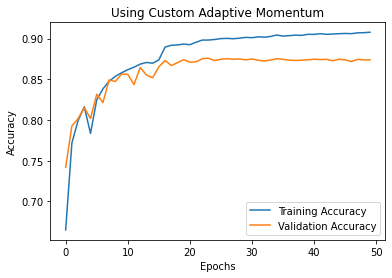

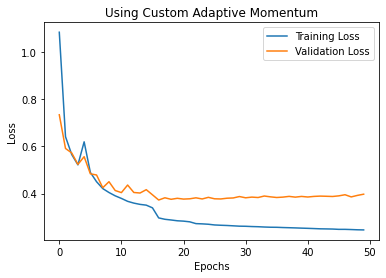

In [ ]:
# Evaluation of the network performance on the test dataset
test_results = mlp_model.evaluate(x=x_test, y=y_test)

plt.figure()
plt.title('Using Custom Adaptive Momentum')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
# Loss
plt.figure()
plt.title('Using Custom Adaptive Momentum')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])

# Checking the accuracy on the test data
print('Test data accuracy using custom adaptive momentum:', test_results[1])

#### Comparing the results to the same network with constant momentum:

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_30 (Dense)             (None, 30)                23550     
_________________________________________________________________
p_re_lu_4 (PReLU)            (None, 30)                30        
_________________________________________________________________
dense_31 (Dense)             (None, 30)                930       
_________________________________________________________________
p_re_lu_5 (PReLU)            (None, 30)                30        
_________________________________________________________________
dense_32 (Dense)             (None, 30)                930       
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 30)                30  

1500/1500 [==============================] - 9s 6ms/step - loss: 0.3186 - acc: 0.8838 - val_loss: 0.4379 - val_acc: 0.8533
Epoch 50/50
313/313 [==============================] - 1s 4ms/step - loss: 0.4250 - acc: 0.8541
Test data accuracy using constant momentum: 0.8540999889373779


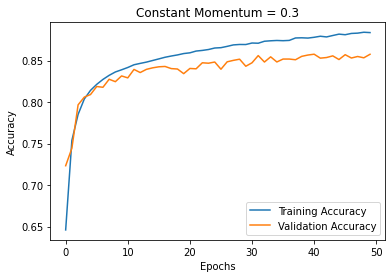

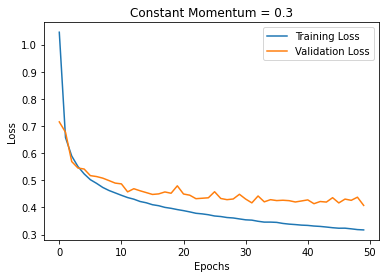

In [ ]:
inp_layer = Input(shape=(784,))
hidden_layer1 = Dense(units=N, activation='linear')(inp_layer)
hidden_layer1 = PReLU()(hidden_layer1)
hidden_layer2 = Dense(units=N, activation='linear')(hidden_layer1)
hidden_layer2 = PReLU()(hidden_layer2)
hidden_layer3 = Dense(units=N, activation='linear')(hidden_layer2)
hidden_layer3 = PReLU()(hidden_layer3)
hidden_layer4 = Dense(units=N, activation='linear')(hidden_layer3)
hidden_layer4 = PReLU()(hidden_layer4)
out_layer = Dense(units=10, activation='softmax')(hidden_layer4)

mlp_model = Model(inputs=inp_layer, outputs=out_layer)

mlp_model.summary()

opt = SGD(learning_rate=0.001, momentum=IM)
mlp_model.compile(optimizer=opt, loss=categorical_crossentropy, metrics='acc')

results = mlp_model.fit(x_train, y_train, epochs=EPO, validation_split=0.2)

# Evaluation of the network performance on the test dataset
test_results = mlp_model.evaluate(x=x_test, y=y_test)

plt.figure()
plt.title(f'Constant Momentum = {IM}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
# Loss
plt.figure()
plt.title(f'Constant Momentum = {IM}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])

# Checking the accuracy on the test data
print('Test data accuracy using constant momentum:', test_results[1])